In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
import os
import scipy.stats as si
import sympy as sy
from matplotlib import rc

In this notebook, we simulate the movement of call and put option prices using the Black-Scholes formula : 

Let $V:= (S_T-K)_+ $ the capital gain of a European call option with maturity T and strike price K. The arbitrage price $V_t$ of V at time $t$ is given by $F(t,S_t)$, where $(t,x) \rightarrow F(t,x)$ is defined as follows :

$$F(t,x) =x N \big( d_1(x) \big) - K e^{-\mu(T-t)} N\big( d_2(x) \big) $$

with : 
$$ N(d) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{d} e^{\frac{-z^2}{2} dz}  $$


$$d_1(x)= \frac{ log\left(\frac{S_0}{K}\right)+(r + \frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T-t}}    $$

$$d_2(x) = d_1(x) -  \sigma \sqrt{T-t}$$

In [2]:
plt.style.use('default')
rc('text', usetex=False)

In [3]:
def d1(S, K, T, r, sigma,t):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t)) / (sigma * np.sqrt(T-t))

def d2(S, K, T, r, sigma,t):
    #return (np.log(S / K) + (r - 0.5 * sigma ** 2) * (T-t)) / (sigma * np.sqrt(T-t))
    return d1(S, K, T, r, sigma,t) - sigma*np.sqrt(T-t)

In [4]:
def call(S, K, T, r, sigma,t):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    if T - t > 0:
        d1val = d1(S, K, T, r, sigma,t)
        d2val  = d2(S, K, T, r, sigma,t) 
        call_val = (S * si.norm.cdf(d1val, 0.0, 1.0) - K * np.exp(-r * (T-t)) * si.norm.cdf(d2val, 0.0, 1.0))
    elif T-t == 0:
        call_val = np.max([S-K,0])
    else:
        print("Error")
    return call_val

In [5]:
def put(S, K, T, r, sigma,t):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    if T - t > 0:
        d1val = d1(S, K, T, r, sigma,t)
        d2val  = d2(S, K, T, r, sigma,t) 
        put_val = (K * np.exp(-r * (T-t)) * si.norm.cdf(-d2val, 0.0, 1.0) - S * si.norm.cdf(-d1val, 0.0, 1.0))
        #put_val= (-S * si.norm.cdf(-d1val, 0.0, 1.0) + K * np.exp(-r * (T-t)) * si.norm.cdf(-d2val, 0.0, 1.0))
    elif T-t == 0:
        put_val = np.max([K-S,0])
    else:
        print("Error")
    return put_val

In [6]:
def function_call (S, K, T, r, sigma,t): 
    Num = len(t)
    call_val = np.zeros(Num)
    for i in range(Num): 
        call_val[i] = call(S[i], K, T, r, sigma,t[i])
    return call_val

In [7]:
def function_put(S, K, T, r, sigma,t):
    Num = len(t)
    put_val = np.zeros(Num)
    for i in range(Num): 
        put_val[i] = put(S[i], K, T, r, sigma,t[i])
    return put_val

In [8]:
seed = 5       
N  = 100

def Brownian(seed, N):
    np.random.seed(seed)                         
    dt = 1./N
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)
    W = np.cumsum(b)
    return W, b


# brownian increments
W, b = Brownian(seed, N)
W = np.insert(W, 0, 0.)

Text(0.5,1,'Brownian Increments')

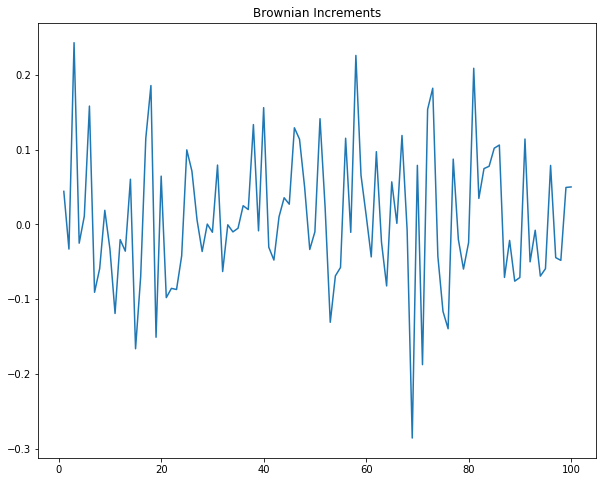

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
xb = np.linspace(1, len(b), len(b))
plt.plot(xb, b)
plt.title('Brownian Increments')

Text(0.5,1,'Brownian Motion')

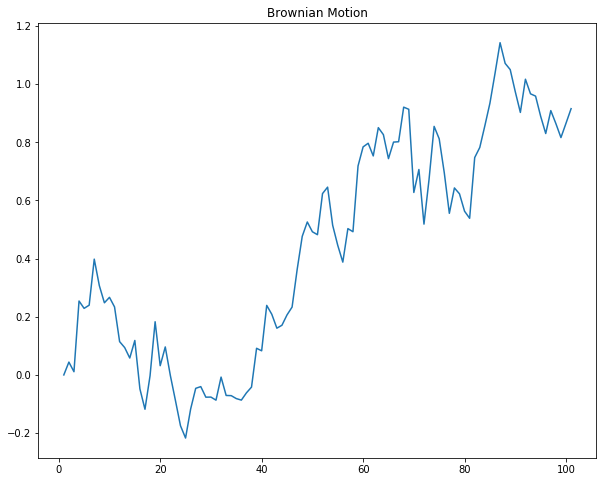

In [10]:
xw = np.linspace(1, len(W), len(W))
plt.plot(xw, W)
plt.title('Brownian Motion')

In [11]:
def GBM(So, mu, sigma, W, T, N):    
    t = np.linspace(0.,1.,N+1)
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t

In [149]:
S0 = 1
mu = 0.15
sigma = 0.4
W = Brownian(20, N)[0]
T = 1.
N = 1000

K_Call = 1
K_Put = 1


sim, t = GBM(S0, mu, sigma, W, T, N)    # Exact solution       # time increments for  plotting

call_vals = function_call(sim, K_Call, T, mu, sigma,t)
put_vals = function_put(sim, K_Put, T, mu, sigma,t)

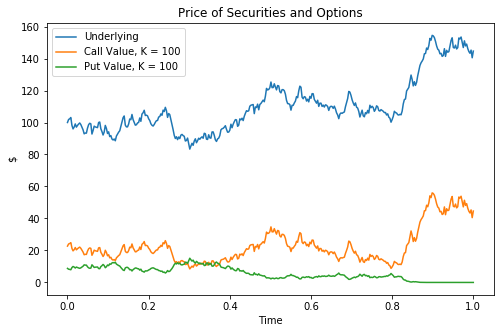

In [14]:
fig, ax = plt.subplots(figsize = (8,5))
plt.plot(t, sim, label = r'Underlying')
plt.plot(t,call_vals,label = r'Call Value, K = ' + str(K_Call))
plt.plot(t, put_vals,label = r'Put Value, K = ' + str(K_Put))

plt.ylabel('$')
plt.xlabel('Time')
plt.title('Price of Securities and Options')
ax.legend()
plt.show()

In [242]:
Ss = []
FinVal = []
BsPut = []
BsCall = []
MCFinPayoff_Put = []
MCFinPayoff_Call = []
n = 1000

for i in range(n):
    W = Brownian(i, N)[0]
    soln, t = GBM(S0, mu, sigma, W, T, N) 
    Ss += [soln]
    FinVal += [soln[-1]]
    BsCall += [function_call(soln, K_Call, T, mu, sigma,t)]
    BsPut += [function_put(soln, K_Put, T, mu, sigma,t)]
    MCFinPayoff_Call += [np.max([Ss[i][-1] - K_Call,0])]
    MCFinPayoff_Put += [np.max([K_Put - Ss[i][-1],0])]

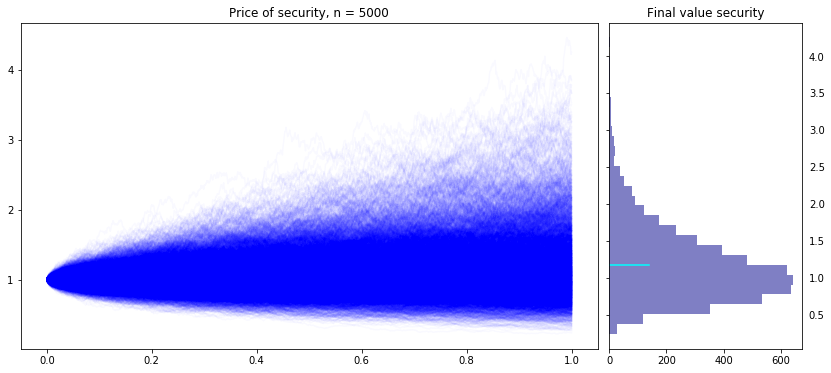

In [243]:
fig, axes = plt.subplots(1, 2, figsize=(14,6),gridspec_kw={'width_ratios': [3, 1]})

axes[0].set_title(r'Price of security, n = '+str(n))
for i in range(n):
    axes[0].plot(t,Ss[i],c='blue',alpha = 0.025)

axes[1].hist(FinVal, bins = 30, color = 'darkblue', orientation = 'horizontal', alpha = 0.5)
plt.subplots_adjust(wspace=0.03, hspace=0)
axes[1].tick_params(axis='y', which='both', labelleft='off', labelright='on')
axes[1].set_title(r"Final value security")
axes[1].plot([0,140],[np.mean(FinVal),np.mean(FinVal)],c='cyan')
plt.show()

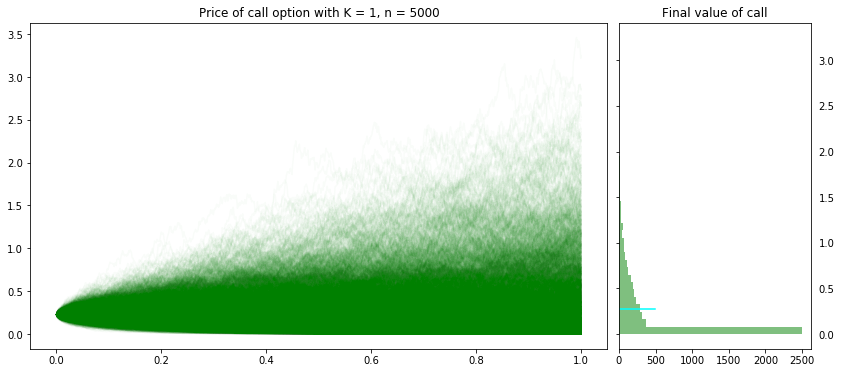

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(14,6),gridspec_kw={'width_ratios': [3, 1]})

axes[0].set_title(r'Price of call option with K = ' + str(K_Call) +', n = '+str(n))
for i in range(n):
    axes[0].plot(t,BsCall[i],c='green',alpha = 0.025)

axes[1].hist(MCFinPayoff_Call, bins = 40, color = 'green', orientation = 'horizontal', alpha = 0.5)
plt.subplots_adjust(wspace=0.03, hspace=0)
axes[1].tick_params(axis='y', which='both', labelleft='off', labelright='on')
axes[1].set_title(r"Final value of call")
axes[1].plot([0,490],[np.mean(MCFinPayoff_Call),np.mean(MCFinPayoff_Call)],c='cyan')
plt.show()

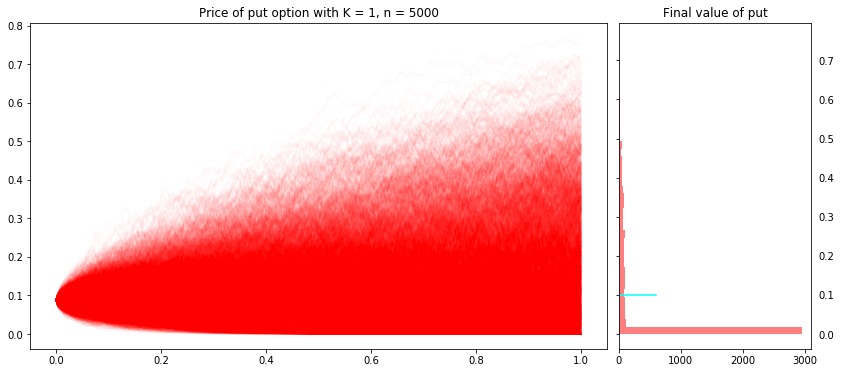

In [245]:
fig, axes = plt.subplots(1, 2, figsize=(14,6),gridspec_kw={'width_ratios': [3, 1]})

axes[0].set_title(r'Price of put option with K = ' + str(K_Put) +', n = '+str(n))
for i in range(n):
    axes[0].plot(t,BsPut[i],c='red',alpha = 0.025)

axes[1].hist(MCFinPayoff_Put, bins = 40, color = 'red', orientation = 'horizontal', alpha = 0.5)
plt.subplots_adjust(wspace=0.03, hspace=0)
axes[1].tick_params(axis='y', which='both', labelleft='off', labelright='on')
axes[1].set_title(r"Final value of put")
axes[1].plot([0,600],[np.mean(MCFinPayoff_Put),np.mean(MCFinPayoff_Put)],c='cyan')
plt.show()

In [299]:
BsCall[1][1]

0.24219552692078095

In [301]:
BsPut[1][1]

0.0822021064296804

In [300]:
mean(MCFinPayoff_Call)

0.27516273594338664

Average Discounted Payoffs

In [250]:
mean(MCFinPayoff_Call)/((1+mu)**T)

0.2392719442985971

In [251]:
mean(MCFinPayoff_Put)/((1+mu)**T)

0.08771866994365422

In [297]:
def portfolio_weights(S, K, T, r, sigma,t):
    
    d1val = d1(S, K, T, r, sigma,t)
    d2val  = d2(S, K, T, r, sigma,t) 
    
    w_risky = si.norm.cdf(d1val, 0.0, 1.0)
    w_riskfree = -K*np.exp(-r*(T-t))*si.norm.cdf(d2val, 0.0, 1.0)
    
    return w_risky, w_riskfree
def period_weights(Prices,K, T, r, sigma,t):
    N = len(t)
    risky_weights = []
    riskfree_weights = []
    for i in range(N-1):
        w = portfolio_weights(Prices[i], K, T, r, sigma,t[i])
        w_risky = w[0]
        w_riskfree = w[1]
        risky_weights += [w_risky]
        riskfree_weights += [w_riskfree]
    return risky_weights, riskfree_weights
def wealth_process(Prices,K, T, r, sigma,t,w):
    Wealth = [w[0][0]*Prices[0]+w[1][0]]
    for i in range(1,len(t)):
        Wealth += [w[0][i-1]*Prices[i] + w[1][i-1]*np.exp(-r*(t[i]-t[i-1]))]
    return Wealth

In [293]:
S0 = 1
mu = 0.15
sigma = 0.4
W = Brownian(5, N)[0]
T = 1.
N = 10000

K_Call = 1
K_Put = 1


sim, t = GBM(S0, mu, sigma, W, T, N)    # Exact solution       # time increments for  plotting

call_vals = function_call(sim, K_Call, T, mu, sigma,t)
put_vals = function_put(sim, K_Put, T, mu, sigma,t)

w = period_weights(sim,K_Call, T, mu, sigma,t)

In [295]:
Wealth = wealth_process(sim,K_Call, T, mu, sigma,t,w)

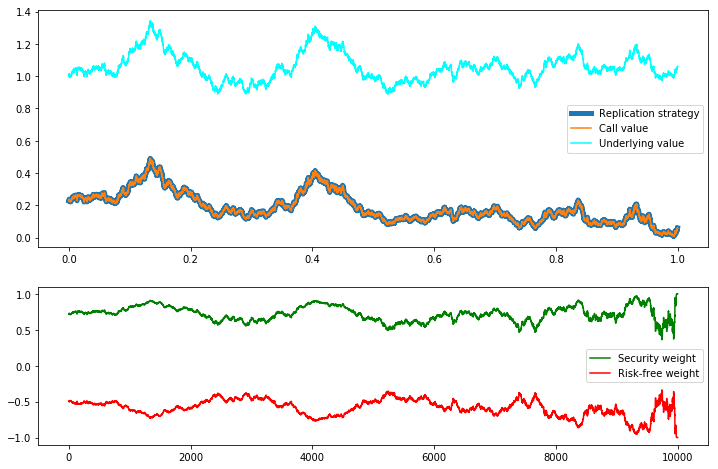

In [296]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), gridspec_kw={'height_ratios': [3,2]})
axes[0].plot(t,Wealth, label = r'Replication strategy', linewidth=5.0)
axes[0].plot(t,call_vals, label = r'Call value')
axes[0].plot(t,sim, label = r'Underlying value', c = 'cyan')
axes[1].plot(w[0], c = 'green',label = r'Security weight')
axes[1].plot(w[1], c = 'red', label = r'Risk-free weight')
axes[0].legend()
axes[1].legend()
plt.show()